## Phylogenetic Analysis of Influencer Genera
__Introduction__
In the vast realm of microbial communities, understanding the evolutionary relationships between different genera is crucial. These relationships can shed light on shared ancestry, functional similarities, and ecological roles. In this notebook, we embark on a journey to unravel these relationships by constructing phylogenetic trees for selected influencer genera.

__Objective__:
The primary goal of this analysis is to visualize the evolutionary relationships between influencer genera based on their sequence data. By doing so, we aim to identify patterns, clusters, and potential evolutionary trajectories.

__Data__:
We utilize sequence data from various genera, which have been aligned to ensure consistency. Alongside, we incorporate abundance data, which provides insights into the prevalence of each genera in different samples.  It is explained in stepwise fashion how the sequences where join with the data previously worked on notebooks 1-4. 


__Workflow__:

1. Data Preparation: We start by visualizing the distribution of sequence lengths to ensure the quality of our alignment. This step ensures that our sequences are comparable.  
2. Sequence ID Modification: To simplify our analysis, we modify sequence IDs to retain only the Genera ID (GID).
3. Distance Calculation: Using the Hamming distance, we compute pairwise distances between sequences. This metric provides a measure of dissimilarity between sequences.
4. Hierarchical Clustering: Based on the computed distances, we perform hierarchical clustering to group similar sequences. The result is a dendrogram that visualizes these groupings.
5. Newick String Conversion: For compatibility with tree visualization tools like iTOL, we convert our dendrogram into the Newick format.
By the end of this notebook, we will have a set of phylogenetic trees that represent the evolutionary relationships between our influencer genera. These trees serve as a foundation for further evolutionary and ecological analyses.
6. Best tree calculation using ModelTest
7. Best model chosing using IQ_tree
8. Consensus tree using IQ_tree

Let's dive in!

In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix
import os
import scipy
from Bio.Align import MultipleSeqAlignment
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

Plotting the distribution of sequence lengths so to know the consistency and quality of the alignment. For instance, after alignment, all sequences should typically have the same length (including gaps). I did a duplicate aligment on Colab that corresponds to output.fasta and aligned.fasta, the visualisation of the two files is as follow, they are identical, so it is possible to work with any of them

In [2]:
# Checking if the file exists
file_path = "data/aligned.fasta"
if os.path.exists(file_path):
    with open(file_path, "r") as fasta_file:
        content = fasta_file.read()
else:
    print(f"Error: {file_path} does not exist.")


In [3]:
#checking if the fasta file has the correct format
try:
    sequences = list(SeqIO.parse(file_path, "fasta"))
except ValueError:
    print(f"Error: {file_path} is not in the correct FASTA format.")


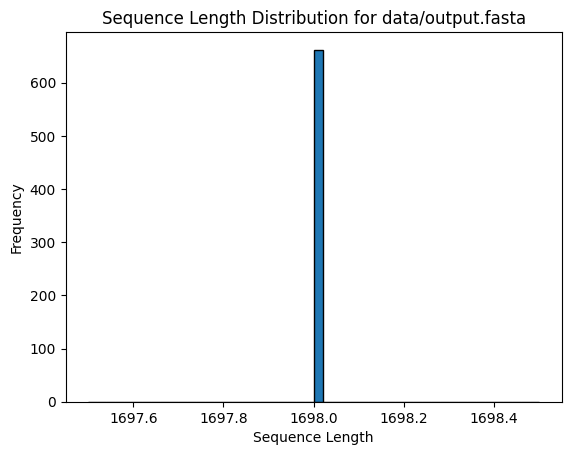

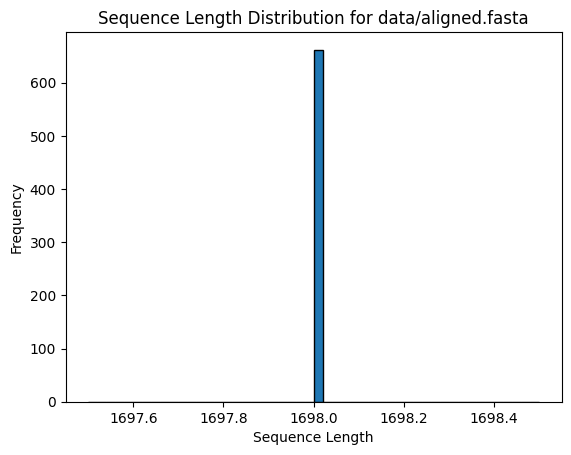

In [4]:
def plot_sequence_lengths(fasta_file):
    lengths = [len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
    
    plt.hist(lengths, bins=50, edgecolor='k')
    plt.title(f"Sequence Length Distribution for {fasta_file}")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.show()

# Visualize the sequence lengths for both files
plot_sequence_lengths("data/output.fasta")
plot_sequence_lengths("data/aligned.fasta")


In [5]:
def read_fasta_data(file_path):
    sequences = list(SeqIO.parse(file_path, "fasta"))
    return sequences

output = read_fasta_data("data/output.fasta")
aligned = read_fasta_data("data/aligned.fasta")

As we see the Aligned sequences have the ID from the genera as the first number and the second number corresponds to the index of the asension number like this id='5_2' then the GID identification number is 5 and 2 is the index of the search of the assension numbers, so this corresponded for that genera to the second found and from this the sequences were extracted. Now I will delete that second number. Firs I Parse the aligned.fasta file. Second modify the IDs to only include the first number before the underscore. Third extract the modified IDs and the aligned sequences.

In [6]:
def extract_sequences(file_path):
    modified_records = []
    
    # Parse the fasta file
    for record in SeqIO.parse(file_path, "fasta"):
        # Modify the ID to only include the first number before the underscore
        record.id = record.id.split('_')[0]
        record.description = ''  # Clear the description
        modified_records.append(record)
    
    return modified_records

# Extract the modified sequences
sequences = extract_sequences("data/aligned.fasta")

# Write the modified sequences to a new fasta file:
with open("data/modified_aligned.fasta", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")


In [7]:
modified_aligned = read_fasta_data("data/modified_aligned.fasta")
modified_aligned 

[SeqRecord(seq=Seq('------------------------------------------------------...---'), id='5', name='5', description='5', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='7', name='7', description='7', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='17', name='17', description='17', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='18', name='18', description='18', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='22', name='22', description='22', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='23', name='23', description='23', dbxrefs=[]),
 SeqRecord(seq=Seq('------------------------------------------------------...---'), id='24', name='24', description='24', dbxrefs=[]),
 SeqRecord(seq=Seq('-----------------------------------------

### Checking for unic GIDs
there is no repeated entries of GIDs as can be seen in the following snipet

In [8]:
# Parse the fasta file
sequences = list(SeqIO.parse("data/modified_aligned.fasta", "fasta"))

# Extract GIDs
gids = [record.id for record in sequences]

# Check for unique GIDs
unique_gids = set(gids)
print(f"Total GIDs: {len(gids)}")
print(f"Unique GIDs: {len(unique_gids)}")

if len(gids) == len(unique_gids):
    print("All GIDs are unique.")
else:
    print("There are duplicate GIDs.")

Total GIDs: 662
Unique GIDs: 662
All GIDs are unique.


The MultipleSeqAlignment class in Biopython is designed to hold a collection of sequences that have been aligned together. A MultipleSeqAlignment object have the same length (due to gaps introduced during the alignment process). Each sequence in the alignment is represented as a SeqRecord object, which contains both the sequence data and associated metadata. Mantaining the order and preserving the metadata that I join previously. 

In [9]:
# Read the FASTA file
with open("data/modified_aligned.fasta", "r") as fasta_file:
     alignment = MultipleSeqAlignment(SeqIO.parse(fasta_file, "fasta"))

# Now 'alignment' is a MultipleSeqAlignment object

The distance between two sequences is usually calculated as the number of differences between them "identity". The 'p-distance', which is simply the proportion of differing characters to the total number of characters. The method for the DistanceCalculator, it calculates the pairwise distance based on the proportion of positions at which the corresponding symbols (nucleotides or amino acids) are different. In other words, it calculates the fraction of mismatches between two sequences.

In [10]:
# Calculate the distance matrix
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)

Construct a Phylogenetic Tree: Using the distance matrix, there are various algorithms to do this, such as UPGMA (Unweighted Pair Group Method with Arithmetic Mean). These algorithm start with each sequence as a separate cluster, and then iteratively join the closest clusters until only one cluster (the root) remains.

In [11]:
# Construct the phylogenetic tree using Neighbor-Joining algorithm
constructor = DistanceTreeConstructor(calculator, 'upgma')  # 'nj' specifies the Neighbor-Joining method
tree = constructor.upgma(dm)

Dendrogram: The length of the branches represents the distance between clusters. 

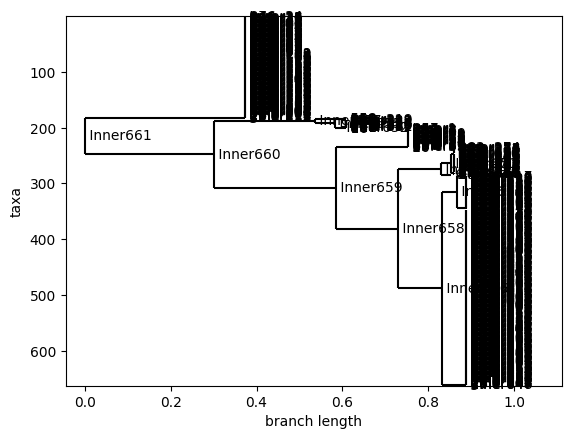

In [12]:
# Draw the dendrogram
Phylo.draw(tree)

Note that this is the dendrogram corresponding to all the genera in the 
data and it is off course too crowded, therefore it is necesary to separate the information to make sense of it.

In [13]:
# 1. Extract sequences and GIDs from the aligned fasta

# Create a list of dictionaries containing GID and sequence data from the fasta file.
# Each dictionary represents a single sequence entry with its GID (record ID) and the actual sequence.
sequence_data = [{"GID": int(record.id), "sequence": str(record.seq)} for record in SeqIO.parse("data/modified_aligned.fasta", "fasta")]

# Convert the list of dictionaries into a pandas DataFrame for easier manipulation and analysis.
sequence_df = pd.DataFrame(sequence_data)

# Set the GID column as the index of the DataFrame for easier referencing.
sequence_df.set_index('GID', inplace=True)

# 1. Inspect actual sequences

# Print the first 10 sequences from the DataFrame to visually inspect them.
print(sequence_df['sequence'].head(10).tolist())

# 2. Check sequence lengths

# Calculate the length of each sequence in the DataFrame.
sequence_lengths = sequence_df['sequence'].apply(len)
unique_lengths = sequence_lengths.unique()
# Check if all sequences have the same length
if len(unique_lengths) > 1:
    print("Warning: Not all sequences have the same length!")

# Print the unique lengths of sequences to check if all sequences have the same length.
print(sequence_lengths.unique())

['-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------AATTCATGCGT-----------------------------------------------------------CCGGACTTCTGCCT----------------------------------------------------------CGAGCCGCCG------------------------------------------------TACACTGGGCCCTGCAAA-----GCTCGTAT--CATCCGTTACT-------TCTACAA-------------TGCAAAGGC-----------------------------------------------------------------------------------------AGGC------CTGTG---------------TCAGACCTTCGT-------------------------------------------------ATACGGCGGTTG---------CCGT---GCTAAGC-GTA------------------ACAA----CTTCAAATCCGC-GGAAGACTGCGAAC-----GTACTTGCGGTGG-------------------------

Now I am goin to add the Metadata that come from the previous notebook which GIDs had been filtered and we have a lower number of Gids.

In [4]:
# Taking the short filtered data version for each category of traffic light called 'data/Influencers_TL1.csv'
# Read the metadata from CSV files
try:
    influencers_1 = pd.read_csv("data/Influencers_TL1.csv")
    influencers_2 = pd.read_csv("data/Influencers_TL2.csv")
    influencers_3 = pd.read_csv("data/Influencers_TL3.csv")
except FileNotFoundError:
    print("Error: One or more files not found!")

Creamos una columna llamada Tax en la df influencers that concatenates the values from the columns corresponding to order, familia and genera.

In [5]:
def add_Tax_column(df):
    """
    Add a 'Tax' column to the DataFrame and place it at the beginning.
    
    Parameters:
    - df: DataFrame with columns 'Order', 'Familia', and 'Genera'.
    
    Returns:
    - DataFrame with the new 'Tax' column at the beginning.
    """
    # Create the 'Tax' column
    df['Tax'] = df['Order'] + "_" + df['Familia'] + "_" + df['Genera']
    
    # Taking out the first 6 columns of the dataframe with the information of tax
    Abundance_influencers = df.iloc[:, 6:]
    
    # Reorder columns 
    cols = Abundance_influencers.columns.tolist()
    # Remove the column 'Tax' and "Influence"
    cols.remove('Tax')
    cols.remove('Influence')
    
    # Insert the removed columns at the start positions 
    cols.insert(0, 'Tax')
    cols.insert(1, 'Influence')
             
    # Reorder the DataFrame columns
    Abundance_influencers = Abundance_influencers[cols]
    
    # Set the column GID as index 
    Abundance_influencers.set_index('GID', inplace=True)
    return Abundance_influencers

In [6]:
# Use the function on our matrices
Abundance_influencers_1 = add_Tax_column(influencers_1)
Abundance_influencers_2 = add_Tax_column(influencers_2)
Abundance_influencers_3 = add_Tax_column(influencers_3)

In [7]:
Abundance_influencers_1.head()

,Tax,Influence,site_2,site_3,site_4,site_5,site_17,site_18,site_21,site_24,site_26,site_28,site_35,site_57,site_58,site_59,site_60,site_69,site_70
GID,,,,,,,,,,,,,,,,,,,
17,Burkholderiales_Comamonadaceae_Acidovorax,17,1.4798,3.7196,3.1293,1.8903,0.2118,3.0578,0.4113,1.9567,0.0040,1.7764,0.0434,1.4495,2.7858,1.8884,0.1014,1.36,1.16
110,Rhodocyclales_Rhodocyclaceae_Azospira,17,1.8592,3.0935,2.5740,2.7094,0.3176,2.2524,36.4445,1.0379,0.0488,0.4852,0.0724,6.4302,0.6532,0.5921,1.5623,1.47,1.72
587,Pseudomonadales_Pseudomonadaceae_Pseudomonas,16,3.4718,2.0624,1.4633,2.4075,2.2763,13.7662,0.1266,0.2135,0.0013,1.5377,0.0145,1.0948,1.4025,1.4995,0.2491,0.00,0.46
491,Sphingomonadales_Sphingomonadaceae_Novosphingo...,16,0.0759,0.2210,0.0397,0.0939,0.8470,0.3649,0.8068,0.1192,0.9870,1.1934,2.9525,1.4958,3.3622,2.2562,1.4698,0.00,3.20
270,Clostridiales_Peptococcaceae_Desulfotomaculum,15,0.2277,1.9642,0.3173,0.3626,22.2340,1.5729,0.3022,13.0562,0.0026,3.7133,0.0000,0.5089,3.4966,3.7662,1.1851,0.00,1.55


The most influential genera top 50 influential genera per category  in each category and how they differ.  

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Selecting the top 50 rows from each dataframe
top_50_1 = Abundance_influencers_1.head(50).drop(columns=['Influence'])
top_50_2 = Abundance_influencers_2.head(50).drop(columns=['Influence'])
top_50_3 = Abundance_influencers_3.head(50).drop(columns=['Influence'])

# Set the 'Tax' column as the index for each dataframe
top_50_1.set_index('Tax', inplace=True)
top_50_2.set_index('Tax', inplace=True)
top_50_3.set_index('Tax', inplace=True)

# Summing the abundance for each category
sum_1 = top_50_1.sum(axis=1)
sum_2 = top_50_2.sum(axis=1)
sum_3 = top_50_3.sum(axis=1)

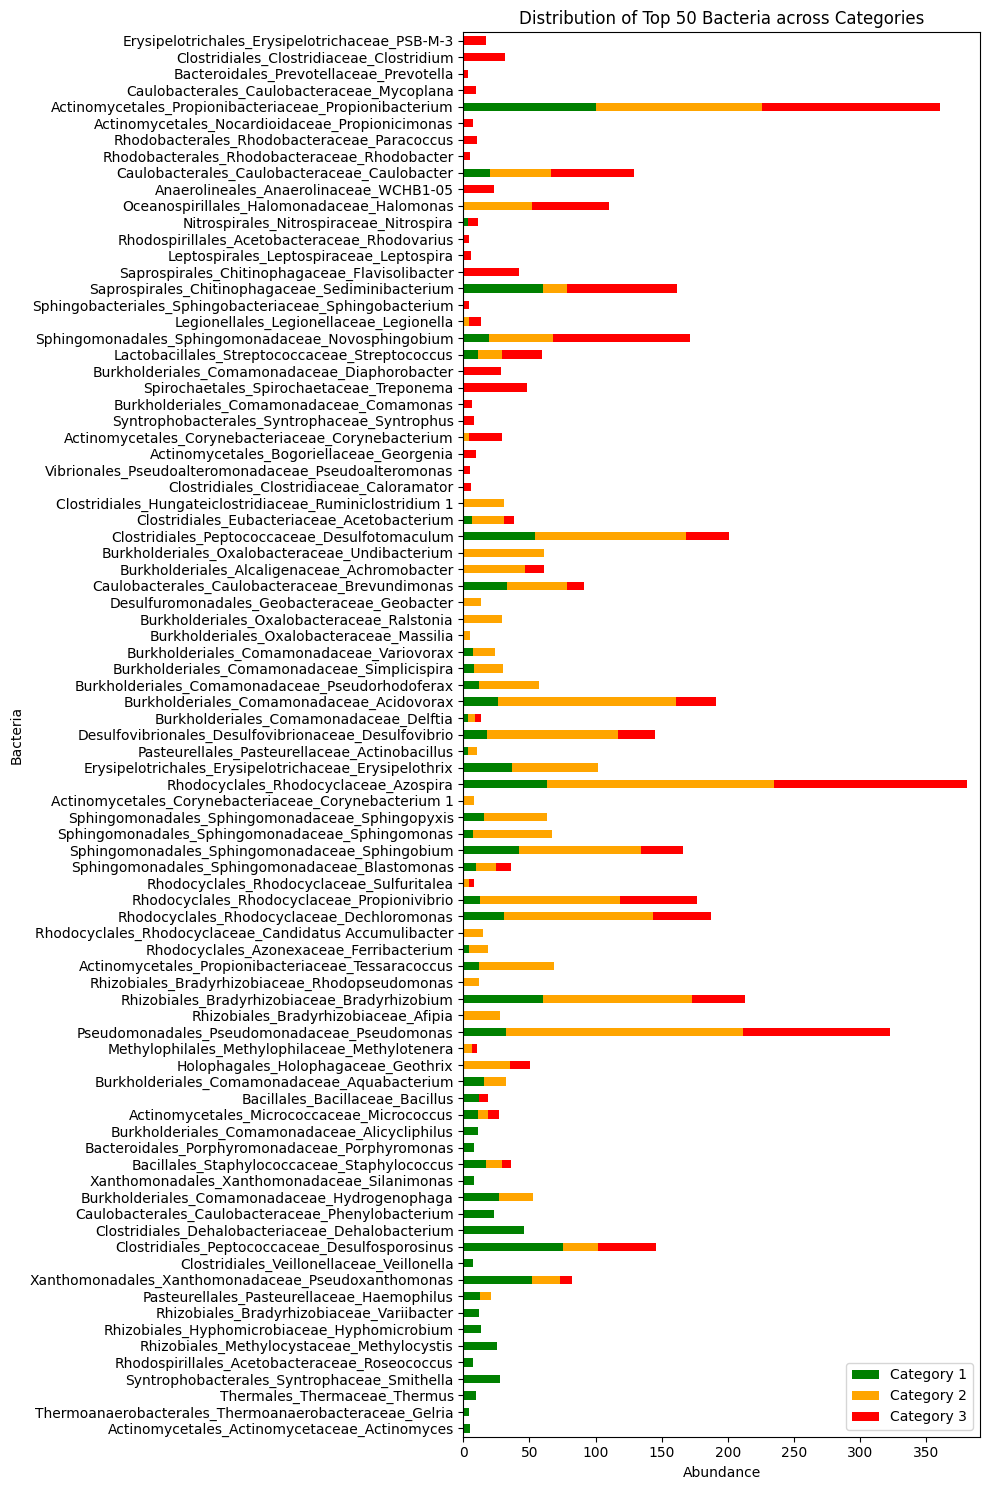

In [9]:
# Combining the summed data into a single dataframe
combined_data = pd.DataFrame({
    'Category 1': sum_1,
    'Category 2': sum_2,
    'Category 3': sum_3
})

# Sorting the dataframe based on the dominant category
combined_data['MaxCategory'] = combined_data.idxmax(axis=1)
combined_data.sort_values(by='MaxCategory', inplace=True)
combined_data.drop(columns=['MaxCategory'], inplace=True)

# Plotting with specified colors
colors = {'Category 1': 'green', 'Category 2': 'orange', 'Category 3': 'red'}
ax = combined_data.plot(kind='barh', stacked=True, figsize=(10, 15), color=[colors[col] for col in combined_data.columns])
plt.title('Distribution of Top 50 Bacteria across Categories')
plt.xlabel('Abundance')
plt.ylabel('Bacteria')

# Adjusting the x-axis limit
ax.set_xlim(0, combined_data.sum(axis=1).max() + 10)  # +10 for a little extra space

plt.tight_layout()
plt.show()

## Can be pathogenic to humans
Combined 50 most dangerous bacteria in terms of abundance and frecuency across categories, this doesnt discriminate on the relevance to corrosion but on all the three categories.

In [10]:
# Print the list of unique bacteria from the combined_data DataFrame
print("Combined List of Unique Bacteria:")
print(combined_data.index.tolist())


Combined List of Unique Bacteria:
['Actinomycetales_Actinomycetaceae_Actinomyces', 'Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria', 'Thermales_Thermaceae_Thermus', 'Syntrophobacterales_Syntrophaceae_Smithella', 'Rhodospirillales_Acetobacteraceae_Roseococcus', 'Rhizobiales_Methylocystaceae_Methylocystis', 'Rhizobiales_Hyphomicrobiaceae_Hyphomicrobium', 'Rhizobiales_Bradyrhizobiaceae_Variibacter', 'Pasteurellales_Pasteurellaceae_Haemophilus', 'Xanthomonadales_Xanthomonadaceae_Pseudoxanthomonas', 'Clostridiales_Veillonellaceae_Veillonella', 'Clostridiales_Peptococcaceae_Desulfosporosinus', 'Clostridiales_Dehalobacteriaceae_Dehalobacterium', 'Caulobacterales_Caulobacteraceae_Phenylobacterium', 'Burkholderiales_Comamonadaceae_Hydrogenophaga', 'Xanthomonadales_Xanthomonadaceae_Silanimonas', 'Bacillales_Staphylococcaceae_Staphylococcus', 'Bacteroidales_Porphyromonadaceae_Porphyromonas', 'Burkholderiales_Comamonadaceae_Alicycliphilus', 'Actinomycetales_Micrococcaceae_Micrococcus', 'Bac

Now the abundance influencers contains the data that has been filtered of abundance or percentaje of each genera in the sample, this is going to be 
join to the data that was taken on notebook 4 of the genera sequences. Sequences dataframe contains all the genera/GIDs without filtering therefore
we want to extract from this total sequences the sequences corresponding to the abundance influencers:

In [11]:
# Filter sequences based on GIDs in Abundance_influencers_1
filtered_sequences_1 = sequence_df[sequence_df.index.isin(Abundance_influencers_1.index)]

# Merge the filtered sequences with Abundance_influencers_1
influence_sequences_1 = Abundance_influencers_1.merge(filtered_sequences_1, left_index=True, right_index=True)
influence_sequences_1.drop(columns=["Influence"], inplace=True) 

NameError: name 'sequence_df' is not defined

In [ ]:
filtered_sequences_2 = sequence_df[sequence_df.index.isin(Abundance_influencers_2.index)]
influence_sequences_2 = Abundance_influencers_2.merge(filtered_sequences_2, left_index=True, right_index=True)
influence_sequences_2.drop(columns=["Influence"], inplace=True)

In [ ]:
filtered_sequences_3 = sequence_df[sequence_df.index.isin(Abundance_influencers_3.index)]
influence_sequences_3 = Abundance_influencers_3.merge(filtered_sequences_3, left_index=True, right_index=True)
influence_sequences_3.drop(columns=["Influence"], inplace=True) 

In [ ]:
Abundance_meta_1= Abundance_influencers_1.drop(columns=["Influence"])
Abundance_meta_1.to_excel('dataml/Abundance_meta_1.xlsx', index=False)
Abundance_meta_2= Abundance_influencers_2.drop(columns=["Influence"])
Abundance_meta_2.to_excel('dataml/Abundance_meta_2.xlsx', index=False)
Abundance_meta_3= Abundance_influencers_3.drop(columns=["Influence"])
Abundance_meta_3.to_excel('dataml/Abundance_meta_3.xlsx', index=False)

In [ ]:
Abundance_meta_1.head()

,Tax,site_2,site_3,site_4,site_5,site_17,site_18,site_21,site_24,site_26,site_28,site_35,site_57,site_58,site_59,site_60,site_69,site_70
GID,,,,,,,,,,,,,,,,,,
17,Burkholderiales_Comamonadaceae_Acidovorax,1.4798,3.7196,3.1293,1.8903,0.2118,3.0578,0.4113,1.9567,0.0040,1.7764,0.0434,1.4495,2.7858,1.8884,0.1014,1.36,1.16
110,Rhodocyclales_Rhodocyclaceae_Azospira,1.8592,3.0935,2.5740,2.7094,0.3176,2.2524,36.4445,1.0379,0.0488,0.4852,0.0724,6.4302,0.6532,0.5921,1.5623,1.47,1.72
587,Pseudomonadales_Pseudomonadaceae_Pseudomonas,3.4718,2.0624,1.4633,2.4075,2.2763,13.7662,0.1266,0.2135,0.0013,1.5377,0.0145,1.0948,1.4025,1.4995,0.2491,0.00,0.46
491,Sphingomonadales_Sphingomonadaceae_Novosphingo...,0.0759,0.2210,0.0397,0.0939,0.8470,0.3649,0.8068,0.1192,0.9870,1.1934,2.9525,1.4958,3.3622,2.2562,1.4698,0.00,3.20
270,Clostridiales_Peptococcaceae_Desulfotomaculum,0.2277,1.9642,0.3173,0.3626,22.2340,1.5729,0.3022,13.0562,0.0026,3.7133,0.0000,0.5089,3.4966,3.7662,1.1851,0.00,1.55


The sequences data are extracted from the respective Tax on their own category

In [ ]:
sequences_dict_1 = influence_sequences_1.set_index('Tax')["sequence"].to_dict()
sequences_dict_2 = influence_sequences_2.set_index('Tax')["sequence"].to_dict()
sequences_dict_3 = influence_sequences_3.set_index('Tax')["sequence"].to_dict()

The following snipets correspond to two different methods to make trees one is neigburh join and the other UPGMA or average. For maximum likehood the local machine can no handle the computational workload and therefore I make that part on google colab under the name 

Calculate the pairwise distances between sequences. One common method for sequences is the Hamming distance,  which calculates the number of differing positions between two strings of equal length

In [ ]:
def hamming_distance(str1, str2):
    """
    Compute the Hamming distance between two strings.
    
    Parameters:
    - str1, str2: Two strings of equal length.
    
    Returns:
    - int: The Hamming distance between the two strings.
    
    Note:
    - The Hamming distance between two strings is the number of positions at which the corresponding symbols are different.
    """
    try:
        return sum(c1 != c2 for c1, c2 in zip(str1, str2))
    except Exception as e: #handle potential error during the operation and make an exception
        print(f"Error calculating Hamming distance: {e}")
        return None

In [ ]:
from Bio.Phylo.TreeConstruction import DistanceMatrix

def compute_distance_matrix(sequences_dict):
    """
    Compute a distance matrix for a dictionary of sequences using the Hamming distance.
    
    Parameters:
    - sequences_dict: A dictionary where keys are sequence identifiers (e.g., Tax values) and values are sequences.
    
    Returns:
    - DistanceMatrix: A distance matrix where rows and columns are sequence identifiers and each cell contains the Hamming distance between two sequences.
    """
    # Convert all keys to strings
    sequences_dict = {str(key): value for key, value in sequences_dict.items()}
    taxa = list(sequences_dict.keys())
    matrix = []

    for i in range(len(taxa)):  # Corrected Tax to taxa here
        row = []
        for j in range(i+1):  # Only compute the lower triangle
            row.append(hamming_distance(sequences_dict[taxa[i]], sequences_dict[taxa[j]]))
        matrix.append(row)

    return DistanceMatrix(taxa, matrix)


In [ ]:
distance_matrix1 = compute_distance_matrix(sequences_dict_1)
distance_matrix2 = compute_distance_matrix(sequences_dict_2)
distance_matrix3 = compute_distance_matrix(sequences_dict_3)
distance_matrix1

In [ ]:
# Checking if the distrance matrix is the correct type
print(type(distance_matrix1))

<class 'Bio.Phylo.TreeConstruction.DistanceMatrix'>


### Hierarchical Clustering: 
visual representation of the relationships between the sequences based on their Hamming distances and perform hierarchical clustering to create dendrograms. 

In [ ]:
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from scipy.cluster.hierarchy import linkage, to_tree, dendrogram
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

def hierarchical_clustering(distance_matrix, method='average'):
    """
    Perform hierarchical clustering and return the linkage matrix or tree.
    
    Parameters:
    - distance_matrix: A distance matrix.
    - method: The linkage algorithm to use. Either 'average', 'single', 'complete', or 'nj' (Neighbor Joining).
    
    Returns:
    -if method is "average", "single", complete" return Z: Linkage matrix if method is 'average', 'single', or 'complete'. Linkage matrix containing the hierarchical clustering information.
         Each row of Z represents a single linkage step and consists of:
         [idx1, idx2, distance, sample_count]
         where idx1 and idx2 are indices of clusters being linked, 
         distance is the distance between these clusters, and 
         sample_count is the number of original samples in the newly formed cluster.
    -if method is "nj", returns a Tree object and posteriorly a Newick string representation of the tree.
    """
    if method in ['average', 'single', 'complete']:
        # Convert distance matrix to a condensed form
        condensed_matrix = squareform(distance_matrix, checks=False)
        # Perform hierarchical clustering
        Z = linkage(condensed_matrix, method=method)
        return Z
    elif method == 'nj':
        calculator = DistanceCalculator('identity')
        constructor = DistanceTreeConstructor(calculator, 'nj')
        tree = constructor.nj(distance_matrix)
        return tree.format("newick")
    else:
        raise ValueError(f"Unsupported method: {method}")

In [ ]:
#if average method is somoed:
Z1 = hierarchical_clustering(distance_matrix1)
Z2 = hierarchical_clustering(distance_matrix2)
Z3 = hierarchical_clustering(distance_matrix3)

In [ ]:
def get_newick(node, newick, parentdist, leaf_names):
    """
    Convert a linkage tree to Newick format.
    """
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = get_newick(node.get_left(), newick, node.dist, leaf_names)
        newick = get_newick(node.get_right(), ",%s" % newick, node.dist, leaf_names)
        newick = "(%s" % newick
        return newick

In [ ]:
def linkage_to_newick(Z, leaf_names=None):
    """
    Convert a linkage matrix to a Newick formatted string.
    
    Parameters:
    - Z: Linkage matrix obtained from hierarchical clustering.
    - leaf_names (optional): List of names for the leaves. If not provided, default names are used.
    
    Returns:
    - newick: Newick formatted string representation of the tree.
    """
    
    tree = scipy.cluster.hierarchy.to_tree(Z, False)
    if leaf_names is not None:
        leaves = leaf_names
    else:
        leaves = list(map(str, range(1, len(Z)+2)))
    newick = get_newick(tree, "", tree.dist, leaves)
    return newick

In [ ]:
newick_1_nj = hierarchical_clustering(distance_matrix1, method='nj')
newick_2_nj = hierarchical_clustering(distance_matrix2, method='nj')
newick_3_nj = hierarchical_clustering(distance_matrix3, method='nj')

In [ ]:
newick_1_Av= linkage_to_newick(Z1)
newick_2_Av= linkage_to_newick(Z2)
newick_3_Av= linkage_to_newick(Z3)

In [ ]:
newick_1_AV.head()

NameError: name 'newick_1_AV' is not defined

In [ ]:
# saving the files to use them on iTOl tool online, using the nj method
with open("data/netwick_1_nj.tree", "w") as file:
    file.write(newick_1_nj)
with open("data/netwick_2_nj.tree", "w") as file:
    file.write(newick_2_nj)
with open("data/netwick_3_nj.tree", "w") as file:
    file.write(newick_3_nj)
    
#using the UPGMA method or average
with open("data/netwick_1_Av.tree", "w") as file:
    file.write(newick_1_Av)
with open("data/netwick_2_Av.tree", "w") as file:
    file.write(newick_2_Av)
with open("data/netwick_3_Av.tree", "w") as file:
    file.write(newick_3_Av)

Visualising the dendrograms before bringing the data to iTol for analyis

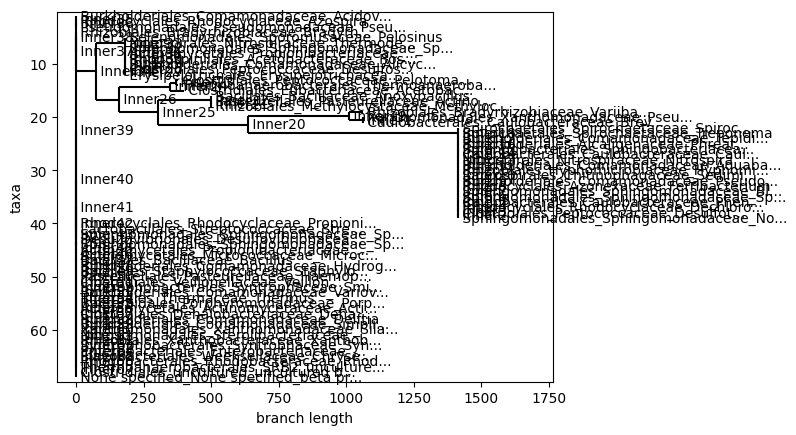

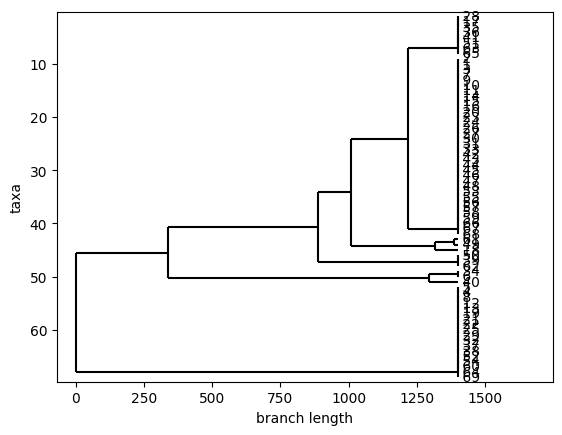

In [ ]:
from Bio import Phylo
from io import StringIO

tree1 = Phylo.read(StringIO(newick_1_nj), "newick")
Phylo.draw(tree1)

tree2 = Phylo.read(StringIO(newick_1_Av), "newick")
Phylo.draw(tree2)

It is desirable to annotate the tree with additional information (e.g., abundance, taxonomy, etc.), iTOL is a suitable tool. It provides a more comprehensive and user-friendly interface for tree visualization and annotation.

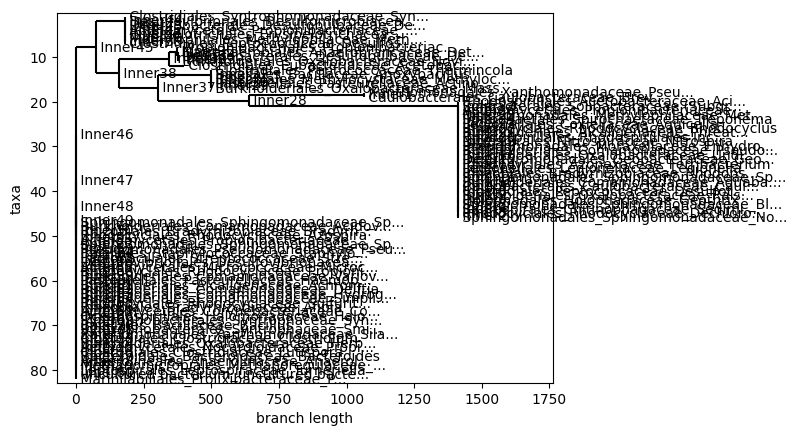

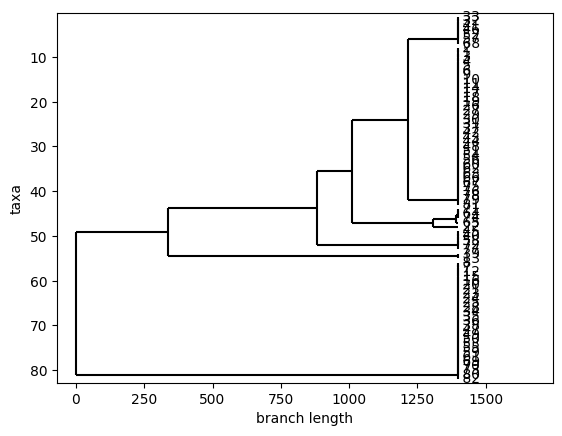

In [ ]:
tree3 = Phylo.read(StringIO(newick_2_nj), "newick")
Phylo.draw(tree3)

tree4= Phylo.read(StringIO(newick_2_Av), "newick")
Phylo.draw(tree4)

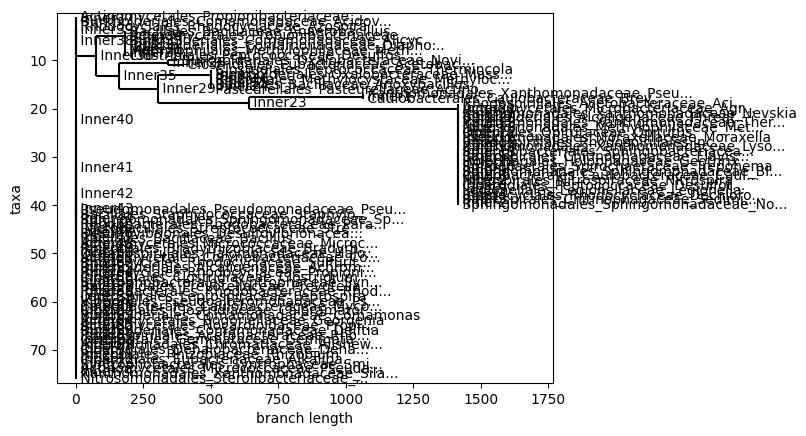

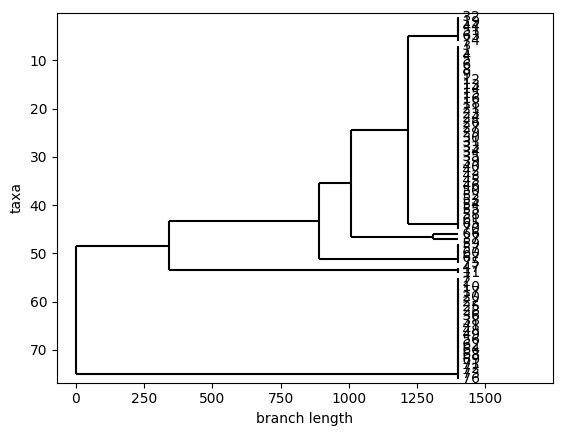

In [ ]:
tree5 = Phylo.read(StringIO(newick_3_nj), "newick")
Phylo.draw(tree5)

tree6 = Phylo.read(StringIO(newick_3_Av), "newick")
Phylo.draw(tree6)

## Maximum likehood

We prepare the data for RAxML and convert the sequences into Fasta format.

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def save_dict_to_fasta(sequences_dict, output_path):
    """
    Save a dictionary of sequences to a FASTA file.

    Parameters:
    - sequences_dict (dict): Dictionary of sequences with Tax as keys and sequences as values.
    - output_path (str): Path to save the FASTA file.
    """
    seq_records = [SeqRecord(Seq(seq), id=tax, description="") for tax, seq in sequences_dict.items()]
    with open(output_path, "w") as output_handle:
        SeqIO.write(seq_records, output_handle, "fasta")

# Save each dictionary to a FASTA file
save_dict_to_fasta(sequences_dict_1, "/dataml/filtered_influencer_sequences_1.fasta")
save_dict_to_fasta(sequences_dict_2, "/dataml/filtered_influencer_sequences_2.fasta")
save_dict_to_fasta(sequences_dict_3, "/dataml/filtered_influencer_sequences_3.fasta")

### Best-fitting model
It's essential to ensure that the chosen evolutionary model accurately represents the processes that shaped the data. For that we use the ModelTest which is a standard approach to determine the best-fitting model for our data. Some common nucleotide substitution models and their characteristics include:  

JC69 (Jukes-Cantor 1969) Model:  
Assumes that all nucleotide substitutions are equally likely,assumes that all nucleotides are equally frequent.  

K80 (Kimura 2-parameter) Model:  
Allows for different rates of transition (e.g., A <-> G or C <-> T) and transversion (e.g., A <-> C, A <-> T, G <-> C, G <-> T) substitutions and assumes all nucleotides are equally frequent.  

HKY85 (Hasegawa, Kishino, and Yano 1985) Model:  
Allows for different rates of transition and transversion substitutions, allows for unequal nucleotide frequencies. 
 
GTR (General Time Reversible) Model:  
The most general model, allows for different substitution rates between all pairs of nucleotides, allows for unequal nucleotide frequencies.

This command would run the software on terminal  
./modeltest-ng-static -i ~/2_MIC_Prediction/data/filtered_influencer_sequences_2.fasta -o model_test_2

The output of the files determined that for tree 1 best model was HKY and for the other two trees was TPM1uf, both are similar by making similar assumptions. TPM stands for "Transitional Probability Matrix". 1 indicates that there's one rate of substitution for transitions (changes between purines [A <-> G] or pyrimidines [C <-> T/U]) and another rate for transversions (changes between a purine and a pyrimidine). uf stands for "unrestricted frequencies", which means the base frequencies (A, C, G, T/U) are estimated from the data and are not assumed to be equal. The HKY model allows for unequal base frequencies (like TPM1uf) and also allows transitions and transversions to occur at different rates. We chose the TPM1uf because the data show unequal base frequences and different rates for transicions and transversions, moreover it is the best for two of the three.

## IQ-TREE:

Maximum Likelihood Estimation: IQ-TREE uses the maximum likelihood criterion to infer phylogenetic trees. ML is a statistical method that finds the tree topology, branch lengths, and substitution parameters that maximize the likelihood of observing the given sequence data given the tree. the model Selection: highlight its ability to perform fast and accurate model selection. It can test multiple substitution models and choose the one that best fits the data.

Ultrafast Bootstrapping: IQ-TREE offers an "ultrafast" bootstrap method that is much faster than traditional methods but still provides a reliable estimation of branch support. And efficient tree Search Algorithms. Utilises Multithreading: utilize multiple CPU cores, which speeds up the analysis. Flexibility: supports various types of molecular sequence data (like DNA, protein) and can handle morphological data as well

At first it was used RAxML, however it was no run in vsc and the repository local because the installation problems. Additionally
after chosing the best tree using the best fitting model of ModelTest, it was decided that the ML method needed to be TPM1uf which is no compatible with RAxML but with iq-tree constructor.

IQ-TREE is primarily a command-line software designed for phylogenetic tree estimation based on maximum likelihood. Once compiled and installed on ubuntu wsl system  

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro/dataml/filtered_influencer_sequences_1.fasta


IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_1.fasta
Seed:    927203 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 15:18:08 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_1.fasta ... Fasta format detected
Reading fasta file: done in 0.0045674 secs using 88.47% CPU
Alignment most likely contains DNA/RNA sequences
Constructing 

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro/dataml/filtered_influencer_sequences_2.fasta


IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_2.fasta
Seed:    839823 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 15:17:50 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_2.fasta ... Fasta format detected
Reading fasta file: done in 0.0042566 secs using 69.84% CPU
Alignment most likely contains DNA/RNA sequences
Constructing 

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro/dataml/filtered_influencer_sequences_3.fasta

IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_3.fasta
Seed:    918181 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 15:18:24 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_3.fasta ... Fasta format detected
Reading fasta file: done in 0.0138299 secs using 98.83% CPU
Alignment most likely contains DNA/RNA sequences
Constructing 

### Model Selection with IQ-Tree:
Before building a tree, we determine the best-fitting substitution model with IQ-TREE to corroborate previous recomended tree TPM1uf.

In [ ]:
#Model selection with IQ-Tree
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro/data/filtered_influencer_sequences_1.fasta -m TEST -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/


IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filtered_influencer_sequences_1.fasta -m TEST -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/
Seed:    803434 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 16:08:18 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filtered_influencer_sequences_1.fasta ... ERROR: File not found /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filt

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro/data/filtered_influencer_sequences_2.fasta -m TEST -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/

IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filtered_influencer_sequences_2.fasta -m TEST -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/
Seed:    784125 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 16:08:19 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filtered_influencer_sequences_2.fasta ... ERROR: File not found /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filt

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro//data/filtered_influencer_sequences_3.fasta -m TEST -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/

IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filtered_influencer_sequences_3.fasta -m TEST -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/
Seed:    106836 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 16:08:21 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filtered_influencer_sequences_3.fasta ... ERROR: File not found /home/beatriz/Leu_Neufische/2_MIC_Prediction/data/filt

### Result from /dataml/iqtrees
The best-fit model according to the Bayesian Information Criterion (BIC) is the K2P (Kimura 2-parameter) model. This model is used for analyzing the tree category trees.

### Bootstrap Analysis:
To evaluate the stability of the inferred tree branches, we conducted a bootstrap analysis with the K2P model. Bootstrapping involves resampling with replacement to test the tree's consistency despite variations. The command for this analysis is provided below:

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/MIC/2_Micro/dataml/filtered_influencer_sequences_1.fasta -bb 1000 -m K2P -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/iqtree_1

IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_1.fasta -bb 1000 -m K2P -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/iqtree_1
Seed:    847189 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 16:26:35 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_1.fasta ... Fasta format detected
Reading fasta file: done in 0.0023

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_2.fasta -bb 1000 -m K2P -redo -pre /home/beatriz/MIC/2_Micro/dataml/iqtree_2

IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_2.fasta -bb 1000 -m K2P -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/iqtree_2
Seed:    761931 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 16:26:46 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_2.fasta ... Fasta format detected
Reading fasta file: done in 0.0028

In [ ]:
!/home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_3.fasta -bb 1000 -m K2P -redo -pre /home/beatriz/MIC/2_Micro/dataml/iqtree_3

IQ-TREE multicore version 2.2.3 COVID-edition for Linux 64-bit built Sep  4 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    Beatriz (AVX2, FMA3, 3 GB RAM)
Command: /home/beatriz/Leu_Neufische/iqtree2/build/iqtree2 -s /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_3.fasta -bb 1000 -m K2P -redo -pre /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/iqtree_3
Seed:    799026 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Sep  4 16:26:56 2023
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 4 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/beatriz/Leu_Neufische/2_MIC_Prediction/dataml/filtered_influencer_sequences_3.fasta ... Fasta format detected
Reading fasta file: done in 0.0025